In [1]:
import sys
sys.path.insert(0, '/Users/nina/Documents/treemap/treemap/analysis')
from config_figures import *

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [3]:
# get ordination and covariate data
df = pd.read_csv('../../data/ordinations_sampled_covariates_1981_2010.csv').drop(['system:index', '.geo'], axis=1)
df

,Axis1,Axis2,Axis3,CHELSA_bio12_1981_2010_V2_1,CHELSA_bio15_1981_2010_V2_1,CHELSA_bio1_1981_2010_V2_1,CHELSA_bio4_1981_2010_V2_1,CHELSA_gsl_1981_2010_V2_1,CHELSA_npp_1981_2010_V2_1,MDS1,MDS2,MDS3,SG_Coarse_fragments_005cm,SG_Silt_Content_005cm,SG_Soil_pH_H2O_005cm,x,y
0,-0.203114,-0.110316,-0.109411,36432.962700,210.218000,2978.865000,502.012200,365.000000,25079.295200,0.647776,-0.294345,0.109215,1.709484,22.444225,42.883077,-85.5,0.5
1,-0.200630,-0.105294,-0.115464,35478.439800,194.474800,2980.997700,473.100500,365.000000,25182.618500,0.613397,-0.362359,0.128936,1.209468,23.118284,42.494265,-84.5,0.5
2,-0.202350,-0.105612,-0.112564,35496.315200,173.247700,2980.079300,450.927800,365.000000,25137.881300,0.650375,-0.368078,0.069564,1.495468,22.953371,42.309594,-83.5,0.5
3,-0.195576,-0.103767,-0.119640,35084.596800,177.327300,2982.499900,449.689900,365.000000,25254.789500,0.688352,-0.280964,0.089301,0.661833,23.515853,42.042120,-82.5,0.5
4,-0.197449,-0.111415,-0.126746,32617.759800,183.492400,2984.814600,454.145500,365.000000,25356.537500,0.597050,-0.399280,0.129519,0.530261,25.933236,41.885098,-81.5,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19530,0.263910,0.008874,-0.319804,3620.331081,849.427928,2562.133483,12368.610661,1.067568,1037.104204,-0.378482,0.375732,-0.424728,23.441461,37.014009,68.585201,-113.5,-95.5
19531,0.263910,0.008874,-0.319804,1784.820226,749.377556,2564.531692,13731.053108,37.862448,1067.435243,-0.393002,0.354893,-0.427902,29.631586,35.108469,69.331893,-105.5,-95.5
19532,0.263910,0.008874,-0.319804,1658.770470,703.070696,2565.979097,15418.188257,59.248569,1085.409666,-0.374453,0.381605,-0.423027,26.971516,35.174600,70.162665,-103.5,-95.5
19533,0.263910,0.008874,-0.319804,1650.206162,712.858674,2560.454655,16089.408171,61.398660,1017.978433,-0.373773,0.390479,-0.419074,25.536506,34.422878,70.305304,-102.5,-95.5


In [4]:
# compute PCA on environmental covariates
df_covs = df[[
    'CHELSA_bio12_1981_2010_V2_1', 'CHELSA_bio15_1981_2010_V2_1', 'CHELSA_bio1_1981_2010_V2_1', 
    'CHELSA_bio4_1981_2010_V2_1', 'CHELSA_gsl_1981_2010_V2_1', 'CHELSA_npp_1981_2010_V2_1', 
    'SG_Coarse_fragments_005cm', 'SG_Silt_Content_005cm', 'SG_Soil_pH_H2O_005cm'
]]
df_st = StandardScaler().fit_transform(df_covs)
pcamodel = PCA(n_components=2)
pca = pd.DataFrame(pcamodel.fit_transform(df_st)).rename(columns = {0:'pc1', 1:'pc2'})
scaled_pca = pca * (1.0 / (pca.max(axis=0) - pca.min(axis=0)))
scaled_pca

,pc1,pc2
0,0.519328,-0.224110
1,0.516155,-0.228334
2,0.516106,-0.232091
3,0.516226,-0.234138
4,0.500042,-0.235581
...,...,...
19530,-0.361684,0.028684
19531,-0.374036,0.021608
19532,-0.377825,0.002127
19533,-0.382103,0.000815


In [5]:
# compute variance explained by PCs
pca_variance_explained = pd.Series(pcamodel.explained_variance_ratio_, index=['pc1','pc2'])
pca_variance_explained

pc1    0.438661
pc2    0.265299
dtype: float64

In [6]:
# compute loadings of environmental covariates in PC space
pca_loadings = pd.DataFrame(pcamodel.components_.T, index = df_covs.columns, columns=['pc1','pc2'])
pca_loadings['var_name'] = ['Annual P', 'P season', 'MAT', 'T season', 'GSL', 'NPP', 'CF', 'Silt', 'pH']
pca_loadings

,pc1,pc2,var_name
CHELSA_bio12_1981_2010_V2_1,0.396485,-0.255255,Annual P
CHELSA_bio15_1981_2010_V2_1,-0.015761,0.472782,P season
CHELSA_bio1_1981_2010_V2_1,0.389414,0.360790,MAT
CHELSA_bio4_1981_2010_V2_1,-0.437968,-0.244094,T season
CHELSA_gsl_1981_2010_V2_1,0.431547,-0.219676,GSL
CHELSA_npp_1981_2010_V2_1,0.481241,-0.116789,NPP
SG_Coarse_fragments_005cm,-0.094441,0.053299,CF
SG_Silt_Content_005cm,-0.215830,-0.453108,Silt
SG_Soil_pH_H2O_005cm,-0.160516,0.501524,pH


In [28]:
# merge ordinations with PCA dataframe
df2 = scaled_pca.join(df[['MDS1','MDS2','MDS3','Axis1','Axis2','Axis3','x','y']])
df2

,pc1,pc2,MDS1,MDS2,MDS3,Axis1,Axis2,Axis3,x,y
0,0.519328,-0.224110,0.647776,-0.294345,0.109215,-0.203114,-0.110316,-0.109411,-85.5,0.5
1,0.516155,-0.228334,0.613397,-0.362359,0.128936,-0.200630,-0.105294,-0.115464,-84.5,0.5
2,0.516106,-0.232091,0.650375,-0.368078,0.069564,-0.202350,-0.105612,-0.112564,-83.5,0.5
3,0.516226,-0.234138,0.688352,-0.280964,0.089301,-0.195576,-0.103767,-0.119640,-82.5,0.5
4,0.500042,-0.235581,0.597050,-0.399280,0.129519,-0.197449,-0.111415,-0.126746,-81.5,0.5
...,...,...,...,...,...,...,...,...,...,...
19530,-0.361684,0.028684,-0.378482,0.375732,-0.424728,0.263910,0.008874,-0.319804,-113.5,-95.5
19531,-0.374036,0.021608,-0.393002,0.354893,-0.427902,0.263910,0.008874,-0.319804,-105.5,-95.5
19532,-0.377825,0.002127,-0.374453,0.381605,-0.423027,0.263910,0.008874,-0.319804,-103.5,-95.5
19533,-0.382103,0.000815,-0.373773,0.390479,-0.419074,0.263910,0.008874,-0.319804,-102.5,-95.5


In [30]:
# scale ordinations (10-90% quantiles mapped to 0-1) for colors
def scale_to_0_1(vec):
    q10 = vec.quantile(0.1)
    q90 = vec.quantile(0.9)
    return vec.apply(lambda x: min(max((x-q10)/(q90-q10), 0), 1))

df2[['MDS1_red','MDS2_green','MDS3_blue']] = df2[['MDS1','MDS2','MDS3']].apply(scale_to_0_1)
nmds_colors = np.array(df2[['MDS1_red','MDS2_green','MDS3_blue']])
df2[['Axis1_green','Axis2_red','Axis3_blue']] = df2[['Axis1','Axis2','Axis3']].apply(scale_to_0_1)
evopca_colors = np.array(df2[['Axis2_red','Axis1_green', 'Axis3_blue']])
df2

,pc1,pc2,MDS1,MDS2,MDS3,Axis1,Axis2,Axis3,x,y,MDS1_red,MDS2_green,MDS3_blue,Axis1_green,Axis2_red,Axis3_blue
0,0.519328,-0.224110,0.647776,-0.294345,0.109215,-0.203114,-0.110316,-0.109411,-85.5,0.5,1.000000,0.000000,0.672169,0.000000,0.065651,0.568248
1,0.516155,-0.228334,0.613397,-0.362359,0.128936,-0.200630,-0.105294,-0.115464,-84.5,0.5,1.000000,0.000000,0.707371,0.000000,0.079729,0.552604
2,0.516106,-0.232091,0.650375,-0.368078,0.069564,-0.202350,-0.105612,-0.112564,-83.5,0.5,1.000000,0.000000,0.601389,0.000000,0.078836,0.560098
3,0.516226,-0.234138,0.688352,-0.280964,0.089301,-0.195576,-0.103767,-0.119640,-82.5,0.5,1.000000,0.022467,0.636620,0.000000,0.084007,0.541811
4,0.500042,-0.235581,0.597050,-0.399280,0.129519,-0.197449,-0.111415,-0.126746,-81.5,0.5,1.000000,0.000000,0.708413,0.000000,0.062570,0.523447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19530,-0.361684,0.028684,-0.378482,0.375732,-0.424728,0.263910,0.008874,-0.319804,-113.5,-95.5,0.089351,1.000000,0.000000,0.509548,0.399737,0.024503
19531,-0.374036,0.021608,-0.393002,0.354893,-0.427902,0.263910,0.008874,-0.319804,-105.5,-95.5,0.074909,1.000000,0.000000,0.509548,0.399737,0.024503
19532,-0.377825,0.002127,-0.374453,0.381605,-0.423027,0.263910,0.008874,-0.319804,-103.5,-95.5,0.093358,1.000000,0.000000,0.509548,0.399737,0.024503
19533,-0.382103,0.000815,-0.373773,0.390479,-0.419074,0.263910,0.008874,-0.319804,-102.5,-95.5,0.094035,1.000000,0.000000,0.509548,0.399737,0.024503


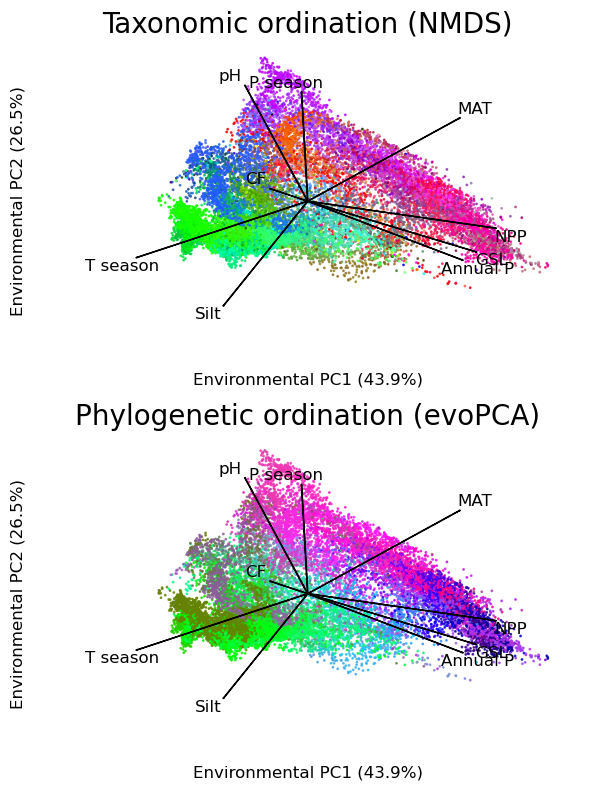

In [31]:
# figure with ordinations mapped into PC space 
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,8))

ax1.scatter(x=df2['pc1'], y=df2['pc2'], c=nmds_colors, s=1, alpha=0.8)
ax1.set_title('Taxonomic ordination (NMDS)', fontsize=20)
ax2.scatter(x=df2['pc1'], y=df2['pc2'], c=evopca_colors, s=1, alpha=0.8)
ax2.set_title('Phylogenetic ordination (evoPCA)', fontsize=20)

for ax in [ax1, ax2]:
    ax.set_xlabel("Environmental PC1 (" + str(pca_variance_explained.pc1.round(3) * 100) + "%)", fontsize=12)
    ax.set_ylabel( "Environmental PC2 (" + str(pca_variance_explained.pc2.round(3) * 100) + "%)", fontsize=12)
    for r in pca_loadings.iterrows():
        ax.arrow(0, 0, r[1]['pc1'], r[1]['pc2'], color = 'k')
        text_x = r[1]['pc1'] + 0.04 if r[1]['pc1'] >= 0 else r[1]['pc1'] - 0.04
        text_y = r[1]['pc2'] + 0.04 if r[1]['pc2'] >= 0 else r[1]['pc2'] - 0.04
        ax.text(text_x, text_y, r[1]['var_name'], color = 'k', ha = 'center', va = 'center', fontsize=12)
    ax.set(xlim = (-0.7, 0.7), ylim = (-0.7, 0.7), xticklabels=[], xticks=[], yticklabels=[], yticks=[])
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

plt.tight_layout()
plt.savefig('../../figures/nmds_evopca_pca.png')

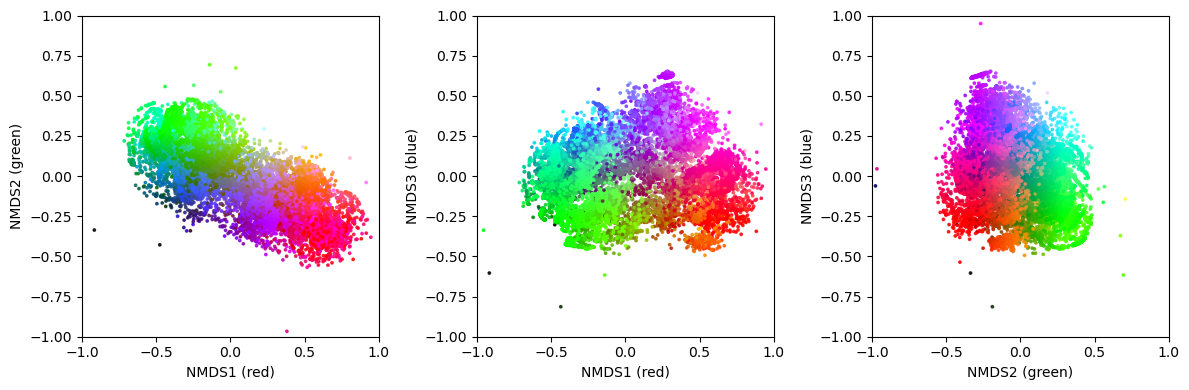

In [33]:
lim = (-1, 1)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))

ax1.scatter(df2['MDS1'], df2['MDS2'], c=nmds_colors, s=3, alpha=0.8)
ax1.set(xlabel ='NMDS1 (red)', ylabel='NMDS2 (green)', xlim=lim, ylim=lim)

ax2.scatter(df2['MDS1'], df2['MDS3'], c=nmds_colors, s=3, alpha=0.8)
ax2.set(xlabel = 'NMDS1 (red)', ylabel='NMDS3 (blue)', xlim=lim, ylim=lim)

ax3.scatter(df2['MDS2'], df2['MDS3'], c=nmds_colors, s=3, alpha=0.8)
ax3.set(xlabel = 'NMDS2 (green)', ylabel='NMDS3 (blue)', xlim=lim, ylim=lim)

plt.tight_layout()
plt.show()

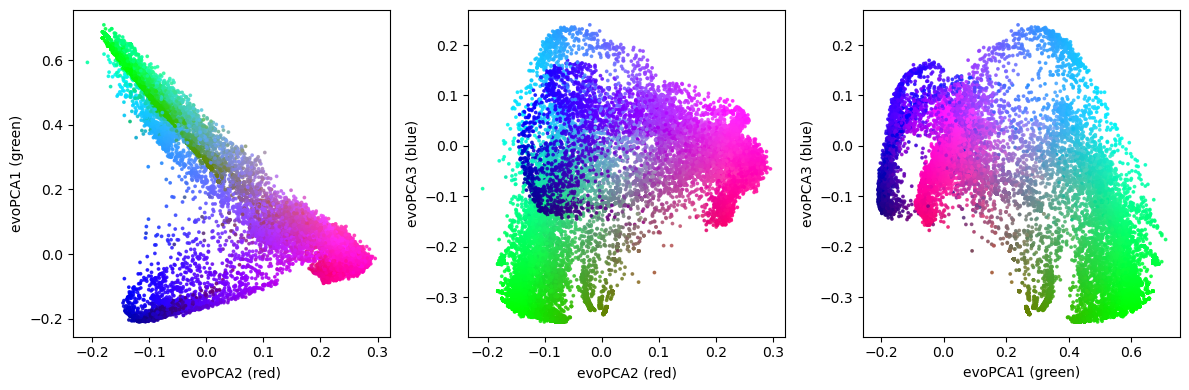

In [35]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))

ax1.scatter(df2['Axis2'], df2['Axis1'], c=evopca_colors, s=3, alpha=0.8)
ax1.set(xlabel ='evoPCA2 (red)', ylabel='evoPCA1 (green)')

ax2.scatter(df2['Axis2'], df2['Axis3'], c=evopca_colors, s=3, alpha=0.8)
ax2.set(xlabel = 'evoPCA2 (red)', ylabel='evoPCA3 (blue)')

ax3.scatter(df2['Axis1'], df2['Axis3'], c=evopca_colors, s=3, alpha=0.8)
ax3.set(xlabel = 'evoPCA1 (green)', ylabel='evoPCA3 (blue)')

plt.tight_layout()
plt.show()

In [36]:
df2

,pc1,pc2,MDS1,MDS2,MDS3,Axis1,Axis2,Axis3,x,y,MDS1_red,MDS2_green,MDS3_blue,Axis1_green,Axis2_red,Axis3_blue
0,0.519328,-0.224110,0.647776,-0.294345,0.109215,-0.203114,-0.110316,-0.109411,-85.5,0.5,1.000000,0.000000,0.672169,0.000000,0.065651,0.568248
1,0.516155,-0.228334,0.613397,-0.362359,0.128936,-0.200630,-0.105294,-0.115464,-84.5,0.5,1.000000,0.000000,0.707371,0.000000,0.079729,0.552604
2,0.516106,-0.232091,0.650375,-0.368078,0.069564,-0.202350,-0.105612,-0.112564,-83.5,0.5,1.000000,0.000000,0.601389,0.000000,0.078836,0.560098
3,0.516226,-0.234138,0.688352,-0.280964,0.089301,-0.195576,-0.103767,-0.119640,-82.5,0.5,1.000000,0.022467,0.636620,0.000000,0.084007,0.541811
4,0.500042,-0.235581,0.597050,-0.399280,0.129519,-0.197449,-0.111415,-0.126746,-81.5,0.5,1.000000,0.000000,0.708413,0.000000,0.062570,0.523447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19530,-0.361684,0.028684,-0.378482,0.375732,-0.424728,0.263910,0.008874,-0.319804,-113.5,-95.5,0.089351,1.000000,0.000000,0.509548,0.399737,0.024503
19531,-0.374036,0.021608,-0.393002,0.354893,-0.427902,0.263910,0.008874,-0.319804,-105.5,-95.5,0.074909,1.000000,0.000000,0.509548,0.399737,0.024503
19532,-0.377825,0.002127,-0.374453,0.381605,-0.423027,0.263910,0.008874,-0.319804,-103.5,-95.5,0.093358,1.000000,0.000000,0.509548,0.399737,0.024503
19533,-0.382103,0.000815,-0.373773,0.390479,-0.419074,0.263910,0.008874,-0.319804,-102.5,-95.5,0.094035,1.000000,0.000000,0.509548,0.399737,0.024503


In [39]:
# remove outliers from ordinations
ordinations = df2[['MDS1','MDS2','MDS3','Axis1','Axis2','Axis3']]
q1 = ordinations.quantile(0.05)
q3 = ordinations.quantile(0.95)
iqr = q3 - q1
df_rm_outliers = df2[ordinations.apply(
    lambda x: (x >= q1[x.name] - 1.5*iqr[x.name]) & (x <= q3[x.name] + 1.5*iqr[x.name])
).all(axis=1)]

# scale ordinations
ordinations = df_rm_outliers[['MDS1','MDS2','MDS3','Axis1','Axis2','Axis3']]
scaler = StandardScaler()
ordinations_scaled = pd.DataFrame(scaler.fit_transform(ordinations), columns = ['MDS1','MDS2','MDS3','Axis1','Axis2','Axis3'])
ordinations_scaled = ordinations_scaled.join(df_rm_outliers[['pc1','pc2','x','y']])
ordinations_scaled

,MDS1,MDS2,MDS3,Axis1,Axis2,Axis3,pc1,pc2,x,y
0,1.696630,-1.364255,0.490002,-1.880747,-0.979269,0.095110,0.519328,-0.224110,-85.5,0.5
1,1.606662,-1.676459,0.580027,-1.870490,-0.940683,0.054492,0.516155,-0.228334,-84.5,0.5
2,1.703432,-1.702712,0.308997,-1.877592,-0.943128,0.073949,0.516106,-0.232091,-83.5,0.5
3,1.802817,-1.302835,0.399093,-1.849613,-0.928957,0.026471,0.516226,-0.234138,-82.5,0.5
4,1.563881,-1.845937,0.582690,-1.857348,-0.987712,-0.021206,0.500042,-0.235581,-81.5,0.5
...,...,...,...,...,...,...,...,...,...,...
19462,-0.989050,1.711575,-1.947427,0.048138,-0.063595,-1.316612,-0.329219,-0.040940,-107.5,-86.5
19463,-1.027047,1.615918,-1.961919,0.048138,-0.063595,-1.316612,-0.344622,-0.038225,-106.5,-86.5
19464,-0.978506,1.738535,-1.939665,0.048138,-0.063595,-1.316612,-0.343134,-0.038200,-105.5,-86.5
19465,-0.976725,1.779266,-1.921617,0.048138,-0.063595,-1.316612,-0.321365,-0.035133,-102.5,-86.5


<BarContainer object of 48 artists>

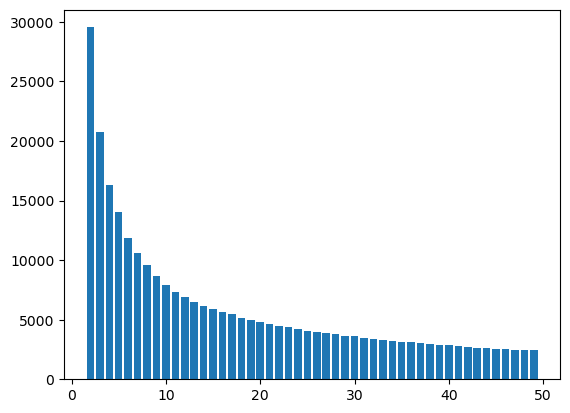

In [42]:
ssd = []
range_n_clusters = range(2, 50)
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(ordinations_scaled[['MDS1','MDS2','MDS3']])
    ssd.append(kmeans.inertia_)

plt.bar(x=range_n_clusters, height=ssd)

In [44]:
# Elbow Method for K means# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30), timings= True)
visualizer.fit(ordinations_scaled[['MDS1','MDS2','MDS3']])        # Fit data to visualizer
visualizer.show()        # Finalize and render figure

ImportError: cannot import name 'safe_indexing' from 'sklearn.utils' (/Users/nina/opt/anaconda3/envs/ee/lib/python3.8/site-packages/sklearn/utils/__init__.py)

<BarContainer object of 48 artists>

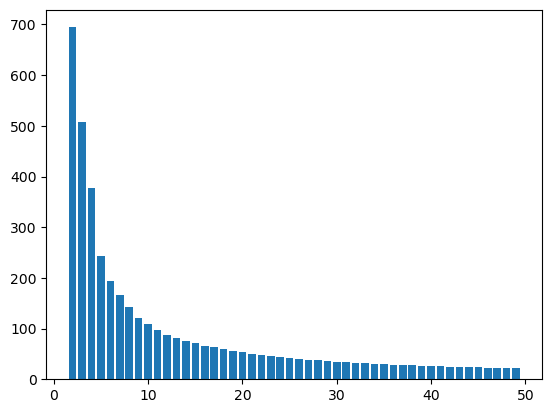

In [43]:
ssd = []
range_n_clusters = range(2, 50)
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(df2[['Axis1','Axis2','Axis3']])
    ssd.append(kmeans.inertia_)
    
plt.bar(x=range_n_clusters, height=ssd)